In [149]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os
#print(os.listdir("../input"))

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',1000)
# Any results you write to the current directory are saved as output.

In [6]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
print ("Data is loaded!")

Data is loaded!


In [90]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object'] # 数量 - 数字
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object'] # 总类

In [10]:
missing = train.isnull().sum()
missing = missing[missing>0]

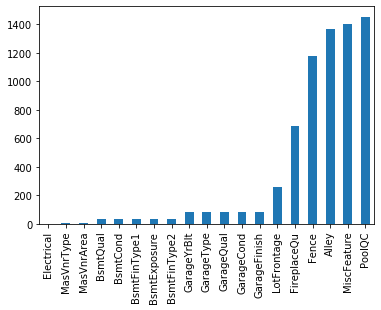

In [13]:
missing.sort_values(inplace = True)
missing.plot.bar()

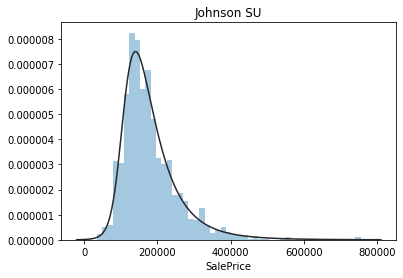

In [14]:
y = train['SalePrice']
plt.figure(1)
plt.title("Johnson SU")
sns.distplot(y,kde = False,fit=stats.johnsonsu) # johnsonsu 

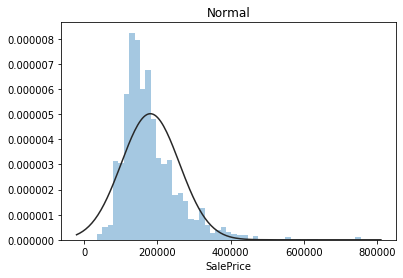

In [15]:
y = train['SalePrice']
plt.figure(1)
plt.title("Normal")
sns.distplot(y,kde = False,fit=stats.norm) # johnsonsu 

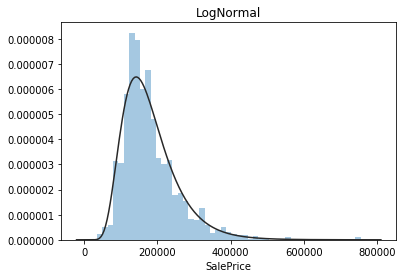

In [16]:
y = train['SalePrice']
plt.figure(1)
plt.title("LogNormal")
sns.distplot(y,kde = False,fit=stats.lognorm) # johnsonsu 

In [17]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal         = pd.DataFrame(train[quantitative])
normal         = normal.apply(test_normality)
print(not normal.any())

False


In [74]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index  = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()  #ordering里面的items是cate-数字之间一一对应;
    
    for cat,o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [85]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
#spearman(train, features)

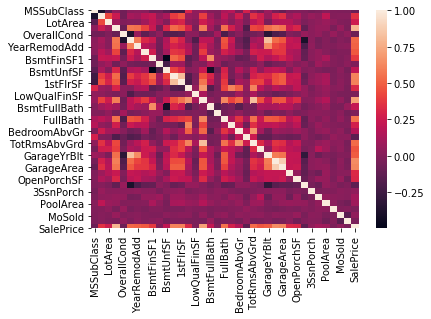

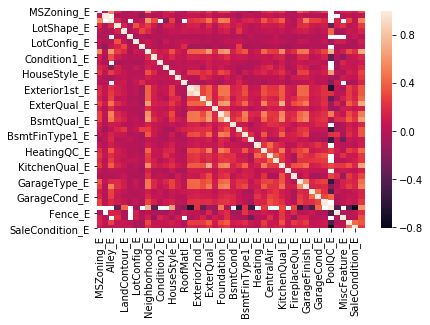

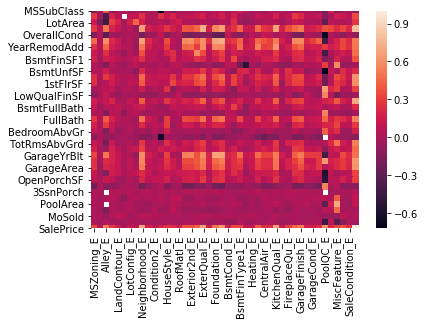

In [86]:
plt.figure(1)
corr = train[quantitative+['SalePrice']].corr()
sns.heatmap(corr)

plt.figure(2)
corr = train[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr)

plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

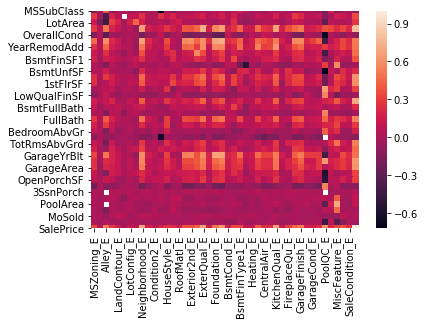

In [93]:
sns.heatmap(corr)

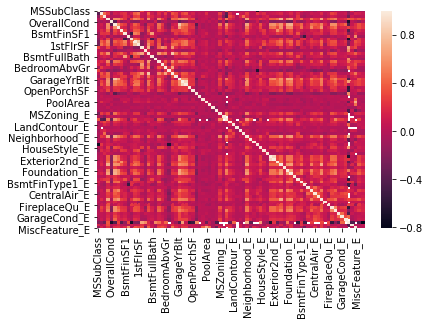

In [96]:
sns.heatmap(train[quantitative].corr())

## 简单聚类 - Simple Clustering 

0.7719627188125653


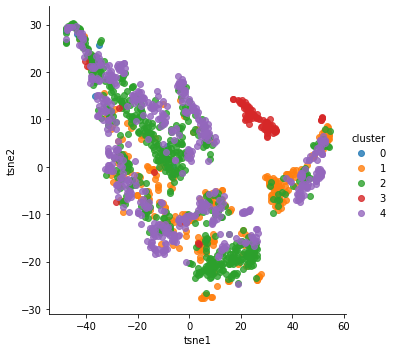

In [98]:
# TSNE - 将高纬度数据数据降维度到2-3维度吗，并画图展示 -  但是缺点是消耗较大的内存
features = quantitative + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

In [99]:
# TSNE 数据降维度在下面的链接: https://www.cnblogs.com/BlueBlueSea/p/10292357.html

## Models

In [100]:
train.drop(['Id'],axis =1,inplace  = True)
test.drop(['Id'],axis =1,inplace  = True)

In [103]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       ...
       'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E',
       'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E',
       'SaleCondition_E'],
      dtype='object', length=123)

In [117]:
train = train[train['GrLivArea']<4500] # 在原来是数据上取出GrLivArea<4500的大小
train.reset_index(drop = True,inplace = True) # 重新设置index 

In [118]:
train['SalePrice'] = np.log1p(train['SalePrice'])
y = train['SalePrice'].reset_index(drop=True)

In [119]:
# feature 
train_feature = train.drop('SalePrice',axis =1)
test_feature  = test
features      = pd.concat([train_feature,test_feature]).reset_index(drop = True)

In [121]:
features.shape

(2917, 122)

In [129]:
# 填充 
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)
features['Functional'] = features['Functional'].fillna('Typ') 
features['Electrical'] = features['Electrical'].fillna("SBrkr") 
features['KitchenQual'] = features['KitchenQual'].fillna("TA") 
features["PoolQC"] = features["PoolQC"].fillna("None")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

In [131]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [132]:
features.head(3)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,Alley_E,BedroomAbvGr,BldgType,BldgType_E,BsmtCond,BsmtCond_E,BsmtExposure,BsmtExposure_E,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType1_E,BsmtFinType2,BsmtFinType2_E,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtQual_E,BsmtUnfSF,CentralAir,CentralAir_E,Condition1,Condition1_E,Condition2,Condition2_E,Electrical,Electrical_E,EnclosedPorch,ExterCond,ExterCond_E,ExterQual,ExterQual_E,Exterior1st,Exterior1st_E,Exterior2nd,Exterior2nd_E,Fence,Fence_E,FireplaceQu,FireplaceQu_E,Fireplaces,Foundation,Foundation_E,FullBath,Functional,Functional_E,GarageArea,GarageCars,GarageCond,GarageCond_E,GarageFinish,GarageFinish_E,GarageQual,GarageQual_E,GarageType,GarageType_E,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HeatingQC_E,Heating_E,HouseStyle,HouseStyle_E,KitchenAbvGr,KitchenQual,KitchenQual_E,LandContour,LandContour_E,LandSlope,LandSlope_E,LotArea,LotConfig,LotConfig_E,LotFrontage,LotShape,LotShape_E,LowQualFinSF,MSSubClass,MSZoning,MSZoning_E,MasVnrArea,MasVnrType,MasVnrType_E,MiscFeature,MiscFeature_E,MiscVal,MoSold,Neighborhood,Neighborhood_E,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PavedDrive_E,PoolArea,PoolQC,PoolQC_E,RoofMatl,RoofMatl_E,RoofStyle,RoofStyle_E,SaleCondition,SaleCondition_E,SaleType,SaleType_E,ScreenPorch,Street,Street_E,TotRmsAbvGrd,TotalBsmtSF,Utilities,Utilities_E,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,NaN,3,1Fam,5.0,TA,3.0,No,1.0,706.0,0.0,GLQ,6.0,Unf,5.0,1.0,0.0,Gd,3.0,150.0,Y,2.0,Norm,5.0,Norm,5.0,SBrkr,5.0,0,TA,4.0,Gd,3.0,VinylSd,12.0,VinylSd,13.0,NaN,NaN,NaN,NaN,0,PConc,6.0,2,Typ,7.0,548.0,2.0,TA,5.0,RFn,2.0,TA,3.0,Attchd,5.0,2003.0,1710,1,GasA,Ex,5.0,6.0,2Story,7.0,1,Gd,3.0,Lvl,2.0,Gtl,1.0,8450,Inside,1.0,65.0,Reg,1.0,0,60,RL,4.0,196.0,BrkFace,3.0,NaN,NaN,0,2,CollgCr,17.0,61,5,7,Y,3.0,0,None,NaN,CompShg,3.0,Gable,2.0,Normal,5.0,WD,5.0,0,Pave,2.0,8,856.0,AllPub,2.0,0,2003,2003,2008
1,1262,0,0,NaN,NaN,3,1Fam,5.0,TA,3.0,Gd,4.0,978.0,0.0,ALQ,4.0,Unf,5.0,0.0,1.0,Gd,3.0,284.0,Y,2.0,Feedr,3.0,Norm,5.0,SBrkr,5.0,0,TA,4.0,TA,2.0,MetalSd,5.0,MetalSd,6.0,NaN,NaN,TA,3.0,1,CBlock,3.0,2,Typ,7.0,460.0,2.0,TA,5.0,RFn,2.0,TA,3.0,Attchd,5.0,1976.0,1262,0,GasA,Ex,5.0,6.0,1Story,6.0,1,TA,2.0,Lvl,2.0,Gtl,1.0,9600,FR2,2.0,80.0,Reg,1.0,0,20,RL,4.0,0.0,None,2.0,NaN,NaN,0,5,Veenker,21.0,0,8,6,Y,3.0,0,None,NaN,CompShg,3.0,Gable,2.0,Normal,5.0,WD,5.0,0,Pave,2.0,6,1262.0,AllPub,2.0,298,1976,1976,2007
2,920,866,0,NaN,NaN,3,1Fam,5.0,TA,3.0,Mn,2.0,486.0,0.0,GLQ,6.0,Unf,5.0,1.0,0.0,Gd,3.0,434.0,Y,2.0,Norm,5.0,Norm,5.0,SBrkr,5.0,0,TA,4.0,Gd,3.0,VinylSd,12.0,VinylSd,13.0,NaN,NaN,TA,3.0,1,PConc,6.0,2,Typ,7.0,608.0,2.0,TA,5.0,RFn,2.0,TA,3.0,Attchd,5.0,2001.0,1786,1,GasA,Ex,5.0,6.0,2Story,7.0,1,Gd,3.0,Lvl,2.0,Gtl,1.0,11250,Inside,1.0,68.0,IR1,2.0,0,60,RL,4.0,162.0,BrkFace,3.0,NaN,NaN,0,9,CollgCr,17.0,42,5,7,Y,3.0,0,None,NaN,CompShg,3.0,Gable,2.0,Normal,5.0,WD,5.0,0,Pave,2.0,6,920.0,AllPub,2.0,0,2001,2002,2008


In [133]:
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

In [134]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

In [137]:
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

In [138]:
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [139]:
features.shape

(2917, 129)

In [140]:
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2917, 376)

In [141]:
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((1458, 376), (1458,), (1459, 376))

In [142]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)

In [143]:
X.shape, y.shape, X_sub.shape

((1453, 375), (1453,), (1459, 375))

In [144]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [145]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [146]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [147]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)

In [150]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [151]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [152]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [153]:
score = cv_rmse(ridge)
score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

LASSO: 0.1005 (0.0147)
 2020-01-16 16:33:16.223506
elastic net: 0.1003 (0.0147)
 2020-01-16 16:35:22.609469
SVR: 0.1009 (0.0116)
 2020-01-16 16:35:38.651333
lightgbm: 0.1058 (0.0150)
 2020-01-16 16:36:10.384779
gbr: 0.1080 (0.0120)
 2020-01-16 16:38:35.339181
[16:38:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:42:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/re

In [154]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
stack_gen
[16:50:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:51:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederr

In [155]:
# Blending Models 
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [156]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.05429629834070995


In [159]:
print('Predict submission')
submission = pd.read_csv("./data/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))

Predict submission


In [160]:
print('Blend with Top Kernels submissions\n')
sub_1 = pd.read_csv('data/House_Prices_submit.csv')
sub_2 = pd.read_csv('data/hybrid_solution.csv')
sub_3 = pd.read_csv('data/lasso_sol22_Median.csv')
submission.iloc[:,1] = np.floor((0.25 * np.floor(np.expm1(blend_models_predict(X_sub)))) + 
                                (0.25 * sub_1.iloc[:,1]) + 
                                (0.25 * sub_2.iloc[:,1]) + 
                                (0.25 * sub_3.iloc[:,1]))

Blend with Top Kernels submissions



In [162]:
submission.head(7)

,Id,SalePrice
0,1461,106176.0
1,1462,142163.0
2,1463,159836.0
3,1464,171917.0
4,1465,165479.0
5,1466,150314.0
6,1467,153686.0
